In [1]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses

print(tf.__version__)

2.10.0


In [2]:
# Download and init dataset
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file("aclImdb_v1", url,
                                    untar=True, cache_dir='.',
                                    cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

train_dir = os.path.join(dataset_dir, 'train')


84125825/84125825 [==============================] - 8s 0us/step


In [3]:
# Verify data
sample_file = os.path.join(train_dir, 'pos/1181_9.txt')
with open(sample_file) as f:
  print(f.read())

Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived.


In [4]:
# Cleanup fodler
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

In [5]:
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='training', 
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


In [6]:
# verify classification
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])

Label 0 corresponds to neg
Label 1 corresponds to pos


In [10]:
# split dataset
raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='validation', 
    seed=seed)

raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/test', 
    batch_size=batch_size)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.


In [11]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

max_features = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

# Make a text-only dataset (without labels), then call adapt
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

# retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b'Recipe for one of the worst movies of all time: a she-male villain who looks like it escaped from the WWF, has terrible aim with a gun that has inconsistent effects (the first guy she shoots catches on fire but when she shoots anyone else they just disappear) and takes time out to pet a deer. Then you got the unlikable characters, 30 year old college students, a lame attempt at a surprise ending and lots, lots more. Avoid at all costs.', shape=(), dtype=string)
Label neg
Vectorized review (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[9249,   15,   28,    5,    2,  241,   91,    5,   30,   58,    4,
           1, 1013,   36,  262,   38,    9, 3923,   35,    2,    1,   43,
         382, 5216,   16,    4, 1115,   12,   43, 5734,  300,    2,   83,
         225,   55, 3208, 3934,   20,  978,   18,   51,   55, 3208,  250,
         320,   34,   40, 4381,    3,  294,   58,   44,    6, 2906,    4,
        6744,   92,   22,  184,    2, 4915,  100, 1221,  337,  161, 

In [12]:
# Verify tokenization 
print("1287 ---> ",vectorize_layer.get_vocabulary()[1287])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

1287 --->  lovely
 313 --->  american
Vocabulary size: 10000


In [13]:
# Set model dataset vars
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

In [14]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [17]:
# Create Model
embedding_dim = 16

model = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(1)])

model.summary()

model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   


 embedding_1 (Embedding)     (None, None, 16)          160016    
                                                                 
 dropout_2 (Dropout)         (None, None, 16)          0         
                                                                 
 global_average_pooling1d_1   (None, 16)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dropout_3 (Dropout)         (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
_________________________________________________________________


In [18]:
# Train Model

epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10


625/625 [==============================] - 13s 20ms/step - loss: 0.6636 - binary_accuracy: 0.6978 - val_loss: 0.6146 - val_binary_accuracy: 0.7714
Epoch 2/10
625/625 [==============================] - 3s 5ms/step - loss: 0.5488 - binary_accuracy: 0.8019 - val_loss: 0.4987 - val_binary_accuracy: 0.8222
Epoch 3/10
625/625 [==============================] - 3s 4ms/step - loss: 0.4448 - binary_accuracy: 0.8456 - val_loss: 0.4204 - val_binary_accuracy: 0.8478
Epoch 4/10
625/625 [==============================] - 2s 4ms/step - loss: 0.3779 - binary_accuracy: 0.8675 - val_loss: 0.3738 - val_binary_accuracy: 0.8610
Epoch 5/10
625/625 [==============================] - 2s 4ms/step - loss: 0.3351 - binary_accuracy: 0.8791 - val_loss: 0.3452 - val_binary_accuracy: 0.8670
Epoch 6/10
625/625 [==============================] - 2s 4ms/step - loss: 0.3052 - binary_accuracy: 0.8873 - val_loss: 0.3262 - val_binary_accuracy: 0.8716
Epoch 7/10
625/625 [==============================] - 2s 4ms/step - loss:

In [19]:
# Evaluate Model
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

782/782 [==============================] - 39s 49ms/step - loss: 0.3108 - binary_accuracy: 0.8728
Loss:  0.3107858896255493
Accuracy:  0.8728399872779846


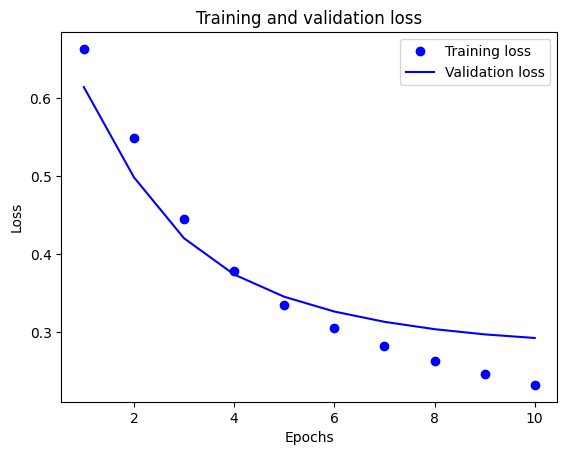

In [20]:
history_dict = history.history
history_dict.keys()

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

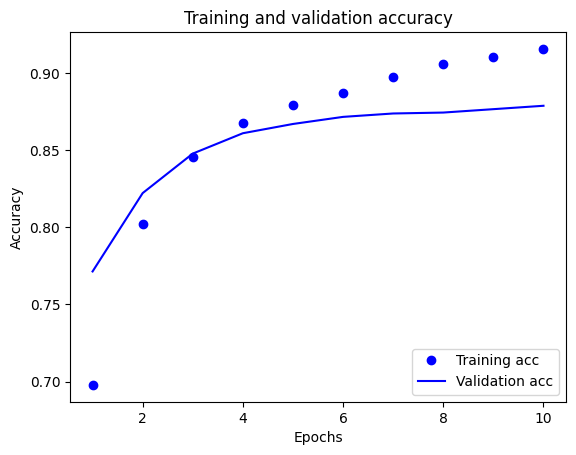

In [21]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In [22]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('sigmoid')
])

export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)

# Test it with `raw_test_ds`, which yields raw strings
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

782/782 [==============================] - 7s 8ms/step - loss: 0.3108 - accuracy: 0.8728
0.8728399872779846


In [23]:
examples = [
  "The movie was great!",
  "The movie was okay.",
  "The movie was terrible..."
]

export_model.predict(examples)

1/1 [==============================] - 0s 126ms/step


array([[0.5989511 ],
       [0.42055443],
       [0.3427619 ]], dtype=float32)